In [2]:
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np
import os
import mne
import scipy
from scipy import stats
from mne.preprocessing import ICA
from mne.preprocessing.ica import corrmap
from mne.time_frequency import psd_welch
import sys
import pickle
import seaborn as sns

#Create Raw file
def CreateRaw(data):
    ch_names = ['F3','F4','cp5','cp6']
    ch_types = ['eeg'] * len(ch_names)
    sfreq=200
    montage = 'standard_1020'
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types,montage=montage, verbose=False)
    raw = mne.io.RawArray(data, info, verbose=False)
    return(raw)

def CreateRaw2(data):
    ch_names = ['F3','F4','cp5']
    ch_types = ['eeg'] * len(ch_names)
    sfreq=200
    montage = 'standard_1020'
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types,montage=montage, verbose=False)
    raw = mne.io.RawArray(data, info, verbose=False)
    return(raw)

def ReadRawFileUgo(file):
    D=[[] for i in range(32)]
    cpt = 0
    with open(file, 'rb') as f:
        while (f.tell() != os.fstat(f.fileno()).st_size):
            (b,) = struct.unpack('f', f.read(4))
            #print(b)
            D[int(cpt % 32)].append(b)
            cpt +=1
    return(np.array(D))

def RawToEpochs(raw,dec):
    events = mne.make_fixed_length_events(raw, id=1, duration=dec)
    epochs = mne.Epochs(raw, events,tmin=0, tmax=5, reject_by_annotation=True, detrend=0, preload=True)
    return(epochs)

def RawToEpochs2(raw,m,dec):
    events = mne.make_fixed_length_events(raw, id=1, duration=dec)
    epochs = mne.Epochs(raw, events,tmin=0, tmax=m, reject_by_annotation=True, detrend=0, preload=True)
    return(epochs)

def RawToEpochs2_picks(raw,m,dec, picks):
    events = mne.make_fixed_length_events(raw, id=1, duration=dec)
    epochs = mne.Epochs(raw, events,tmin=0, tmax=m, picks = picks, reject_by_annotation=True, detrend=0, preload=True)
    return(epochs)




## Ouvre le fichier sur lequel on veut travailler

In [91]:
os.listdir("C:\\Users\\zeta\\documents\\EEG_polysomno\\PSG_tamtin_nox")
%matplotlib qt
os.chdir("C:\\Users\\zeta\\documents\\EEG_polysomno\\PSG_tamtin_nox")

filename="1DA15_nuit_hab.edf"

RAW= mne.io.read_raw_edf(filename, preload=True)
RAW = RAW.filter(20., 99., n_jobs=1, fir_design='firwin', filter_length='auto', phase='zero-double')
print(RAW.info["ch_names"])
chan=RAW.info["ch_names"]

Extracting EDF parameters from C:\Users\zeta\documents\EEG_polysomno\PSG_tamtin_nox\1DA15_nuit_hab.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5885999  =      0.000 ... 29429.995 secs...


<ipython-input-91-24c9cc3a3aa7>:7: RuntimeWarning: 6 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  RAW= mne.io.read_raw_edf(filename, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 20 - 99 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-12 dB cutoff frequency: 17.50 Hz)
- Upper passband edge: 99.00 Hz
- Upper transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 99.50 Hz)
- Filter length: 661 samples (3.305 sec)

['1', '1 Imp?dance', '1-2', '1-F', '2', '2 Imp?dance', '2-F', 'Abdomen', 'Abdomen CaL', 'Activity', 'X Axis', 'Y Axis', 'Z Axis', 'C3', 'C3 Imp?dance', 'C3-M2', 'C4', 'C4 Imp?dance', 'C4-M1', 'E1', 'E1 Imp?dance', 'E1-M2', 'E2', 'E2 Imp?dance', 'E2-M1', 'ECG', 'ECG Imp?dance', 'F', 'F Imp?dance', 'F3', 'F3 Imp?dance', 'F3-M2', 'F4', 'F4 Imp?dance', 'F4-M1', 'Airflow', 'RIP Flow Cal', 'RIP Flow', 'Resp Rate', '

## Convertit en Epochs et prend juste les channels d'intérêt de la machoire:

In [92]:
chan=RAW.info["ch_names"]
mach1= chan.index("1")
mach2= chan.index("2")
Epo= RawToEpochs2_picks(RAW,0.25,0.25, [mach1])


117720 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 117720 events and 51 original time points ...
1 bad epochs dropped


## Calcule les puissances de chaque epoch et les stacke dans la liste pwrs

In [93]:
#print(Epo[0].get_data())
pwrs=[]
print(len(Epo))
compt=0
for ep in Epo:
    if compt==0:
        print (ep[0])
    pwr=0
    for elm in ep[0]:
        pwr+=elm*elm
    pwrs.append(pwr)
    compt+=1
print(len(pwrs))

117719
[ 0.00000000e+00  2.02219773e-05  1.08906027e-05  4.85666369e-06
  1.80233918e-06 -9.33509776e-07 -1.53559748e-06 -6.46678738e-07
 -2.99623412e-05  5.78713397e-06  3.95336330e-06  1.11700839e-05
 -1.42956832e-05  1.37156022e-05  1.66948054e-05  4.34310580e-06
  1.98186408e-06 -2.41634124e-05 -2.21332131e-05 -6.27692918e-06
  2.51736227e-05  1.74730041e-05 -4.18619854e-06 -8.83721887e-06
 -1.43523522e-05  2.65350106e-05 -1.10369128e-07 -8.41059565e-06
 -4.49132627e-06 -5.79779787e-06  3.62001969e-06 -5.98243787e-06
  1.85155260e-07  4.24800264e-06  5.39412023e-06  1.46580382e-05
  2.89916648e-06 -1.41220116e-05 -2.30607116e-05  2.12259076e-05
  1.84744872e-06 -2.72604296e-05  1.84923016e-05  1.11976282e-05
  1.09583242e-06 -8.66637560e-06  1.01654512e-05 -5.90780990e-06
  7.64498578e-06 -3.00680156e-05  4.15879751e-06]
117719


## Créé l_detect qui marque les epoch ou la puissance est au dessus de 10 fois la valeur moyenne

In [108]:
meany =np.mean(pwrs)
l_detect=[]
compti=0
for elm in pwrs:
    if elm> 10* meany:
        l_detect.append(1)
        compti+=1
    else: 
        l_detect.append(0)
print(compti)

1725


## Affichage de l_detect

In [110]:
%matplotlib qt

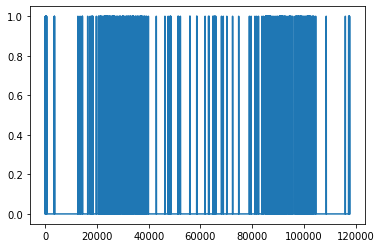

In [106]:
plt.figure()
plt.plot(l_detect)

## Fonction qui permet de creer des annotations sur le plot du raw à partir de l_detect

In [107]:
def Annotate(RAW, li, m=0.25, n=0.25):
    #annotations = mne.Annotations([0], [0], "Start")
    if len(RAW.annotations)>0:
        for i in range(len(RAW.annotations)):
            RAW.annotations.delete(0)
    for i in range(len(li)):
        if li[i]==1:
            RAW.annotations.append([n * i], [m], str("bad EPOCH"))
        #else:
        #    '''Detection mauvais channels dans l'epoch et interpole '''
        #    DetectBad(epoch)
            
    
    return

## Permet de faire l'afficchage du signal avec les annotations correspondant aux detections

['1', '2', 'F']


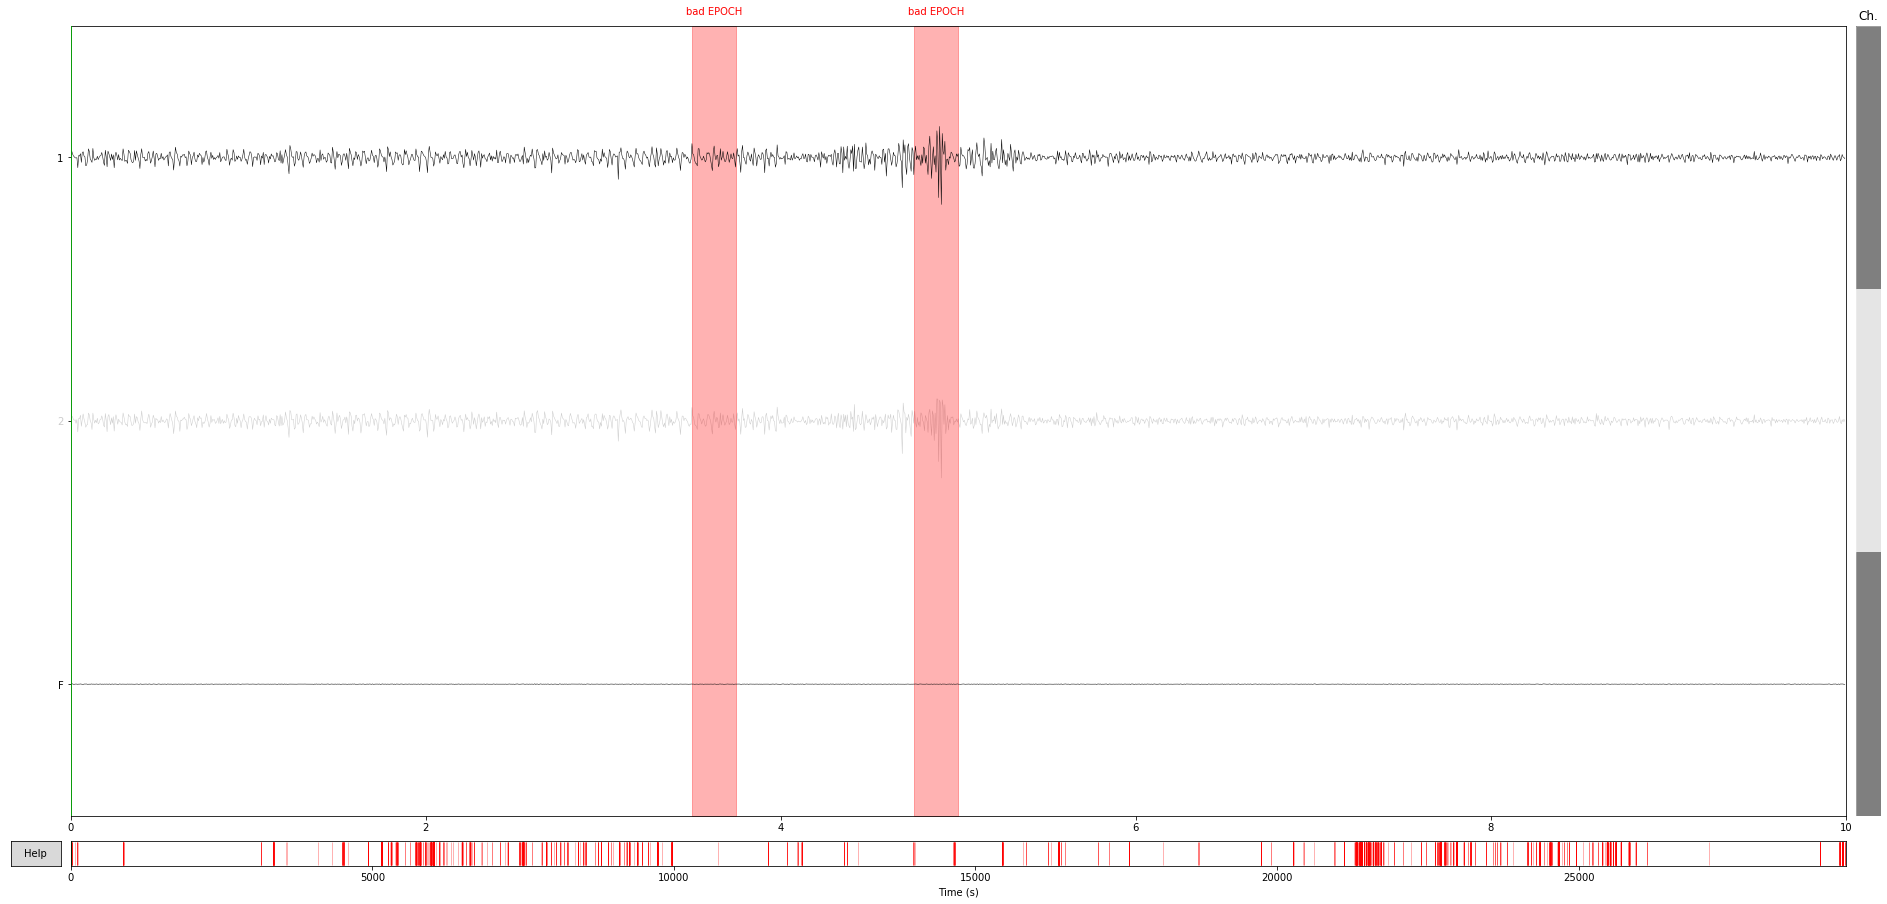

In [111]:
import copy
li=[1,5,28] #impedance channels machoire
chan=RAW.info["ch_names"]


def all_chan_but(lis, chan):
    ret=[]
    for val in chan:
        if not lis.__contains__(val):
            ret.append(val)
    return ret


get_c3=all_chan_but(["1","2","F"], chan)
#get_c3=all_chan_but(["1-2","1-F","2-F"], chan)
li= RAW.info["ch_names"]
print(li)
RAW.drop_channels(get_c3)
#RAW.drop_channels(["Activity","X Axis","Y Axis","Z Axis", "Heart Rate","PosAngle", "Audio Volume dB", "1","1-2",
#                  "1-F","2","2-F","M2 Impedance"])

#RAW = RAW.filter(20., 99., n_jobs=1, fir_design='firwin', filter_length='auto', phase='zero-double')

#On ne prend en compte que les 20 000 premieres annotations
anno = Annotate(RAW,l_detect)
#RAW.annotations = anno
RAW.plot(scalings = 'auto', n_channels = 4)

In [76]:
print(RAW.annotations)

<Annotations  |  0 segments , orig_time : 2019-11-27 23:03:33>


In [29]:
import pandas as pd
li=RAW["1"][:1000][0][0][1000000:1500000]
df = pd.DataFrame(li,columns=['signal'])

In [30]:
df.to_csv('chan_1.csv',sep=';', encoding='utf-8')


In [33]:
print(len(df)/(200*60))

41.666666666666664


In [9]:
%matplotlib inline

## Affiche les distributions des epochs créés

[ 0.00000000e+00  2.02219773e-05  1.08906027e-05  4.85666369e-06
  1.80233918e-06 -9.33509776e-07 -1.53559748e-06 -6.46678738e-07
 -2.99623412e-05  5.78713397e-06  3.95336330e-06  1.11700839e-05
 -1.42956832e-05  1.37156022e-05  1.66948054e-05  4.34310580e-06
  1.98186408e-06 -2.41634124e-05 -2.21332131e-05 -6.27692918e-06
  2.51736227e-05  1.74730041e-05 -4.18619854e-06 -8.83721887e-06
 -1.43523522e-05  2.65350106e-05 -1.10369128e-07 -8.41059565e-06
 -4.49132627e-06 -5.79779787e-06  3.62001969e-06 -5.98243787e-06
  1.85155260e-07  4.24800264e-06  5.39412023e-06  1.46580382e-05
  2.89916648e-06 -1.41220116e-05 -2.30607116e-05  2.12259076e-05
  1.84744872e-06 -2.72604296e-05  1.84923016e-05  1.11976282e-05
  1.09583242e-06 -8.66637560e-06  1.01654512e-05 -5.90780990e-06
  7.64498578e-06 -3.00680156e-05  4.15879751e-06  1.54257229e-05
  6.71385764e-06 -6.97372689e-06  8.64971929e-06 -7.40432861e-06
 -2.68623071e-06 -6.36398255e-06 -9.12013812e-06  2.52501331e-05
  1.00573547e-05 -1.14914

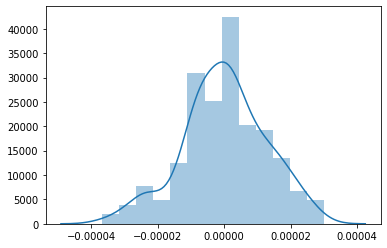

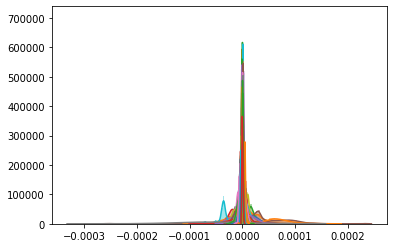

In [10]:
print(Epo[0].get_data()[0][0])
plt.figure()
sns.distplot(Epo[0].get_data()[0][0])

plt.figure()
print(int(len(Epo)/100))
for i in range(int(len(Epo)/100)):
    sns.distplot(Epo[100*i].get_data()[0][0])

## Créé les transformées de Fourier (Welch) des epochs et récupère les coefficients entre 20 et 100 Hz

In [11]:
#Epo.plot(scalings = 'auto', n_channels = 3)
def Extract_Alpha(E):
        AP = []
        print (len(E))
        flag = 0
        for epoch in E:

            #print len(epoch[0])

            #Il se passe des choses bizarres ici !! 

            FFTBIS = scipy.signal.welch(epoch, fs=200.0, window='hanning')
            if flag == 0 :
                print (len(epoch))
                print (FFTBIS[0][20:100])
                print (len(FFTBIS[0]))
                flag = 1
            ap = 0
            
            ap=FFTBIS[1][0][20:100]    #seulement la channel 1, de 20Hz à 50Hz
            
            AP.append(ap)


        return(AP)

get_al=Extract_Alpha(Epo)
print(get_al[:10])

29429
2
[19.90049751 20.89552239 21.89054726 22.88557214 23.88059701 24.87562189
 25.87064677 26.86567164 27.86069652 28.85572139 29.85074627 30.84577114
 31.84079602 32.8358209  33.83084577 34.82587065 35.82089552 36.8159204
 37.81094527 38.80597015 39.80099502 40.7960199  41.79104478 42.78606965
 43.78109453 44.7761194  45.77114428 46.76616915 47.76119403 48.75621891
 49.75124378 50.74626866 51.74129353 52.73631841 53.73134328 54.72636816
 55.72139303 56.71641791 57.71144279 58.70646766 59.70149254 60.69651741
 61.69154229 62.68656716 63.68159204 64.67661692 65.67164179 66.66666667
 67.66169154 68.65671642 69.65174129 70.64676617 71.64179104 72.63681592
 73.6318408  74.62686567 75.62189055 76.61691542 77.6119403  78.60696517
 79.60199005 80.59701493 81.5920398  82.58706468 83.58208955 84.57711443
 85.5721393  86.56716418 87.56218905 88.55721393 89.55223881 90.54726368
 91.54228856 92.53731343 93.53233831 94.52736318 95.52238806 96.51741294
 97.51243781 98.50746269]
101


C:\Users\Zeta\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1970: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


[array([1.78817639e-14, 9.39246437e-13, 1.90174546e-12, 2.91144261e-12,
       1.94897252e-12, 3.49008856e-12, 1.18358711e-11, 8.73651164e-12,
       4.31952975e-12, 5.92766131e-13, 1.39044439e-11, 1.19811526e-11,
       9.51902121e-13, 1.14793592e-13, 9.85815193e-14, 1.81967100e-14,
       6.40714092e-13, 3.85430369e-12, 7.45441804e-12, 8.03404713e-12,
       3.06826418e-12, 3.00511385e-12, 6.50694467e-14, 1.83803733e-12,
       5.70504712e-12, 2.69034914e-12, 6.18371901e-13, 1.21419587e-12,
       5.99148251e-12, 5.95468989e-12, 9.18142444e-13, 4.41708319e-13,
       1.06859149e-13, 1.89171154e-12, 2.09920606e-13, 1.82784130e-13,
       2.23142363e-12, 1.99931993e-12, 1.88288758e-12, 7.45692139e-13,
       1.30159625e-13, 8.25518046e-13, 7.24505350e-13, 7.79577921e-13,
       2.55831226e-12, 3.33562140e-12, 2.70061734e-12, 6.02913026e-13,
       4.50161527e-13, 3.53774809e-12, 2.97294355e-12, 9.11889249e-13,
       1.22798753e-12, 3.01890656e-13, 2.12128307e-13, 2.16402441e-12,
     

## Affiche l'ensemble des FFTs précedemment calculées

294


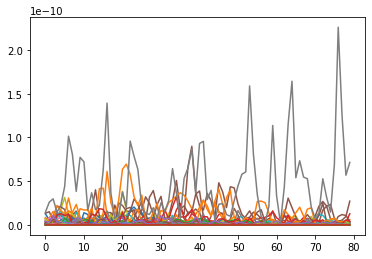

In [12]:
plt.figure()
print(int(len(get_al)/100))
for i in range(int(len(get_al)/100)):
    plt.plot(get_al[100*i])